## Winoground BLIP

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Install Dependencies

In [1]:
!pip3 install transformers==4.15.0 timm==0.4.12 fairscale==0.4.6
!pip install datasets
!git clone https://github.com/salesforce/BLIP
%cd BLIP

     |████████████████████████████████| 3.4 MB 1.3 MB/s            
     |████████████████████████████████| 376 kB 23.9 MB/s            
     |████████████████████████████████| 235 kB 34.7 MB/s            
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     |████████████████████████████████| 3.3 MB 50.6 MB/s            
     |████████████████████████████████| 603 kB 29.3 MB/s            
     |████████████████████████████████| 880 kB 31.5 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 78 kB 7.0 MB/s             
     |████████████████████████████████| 67 kB 5.3 MB/s             
     |████████████████████████████████| 751 kB 30.8 MB/s            
     |████████████████████████████████| 881.9 MB 5.9 kB/s             
     |████████████████████████████████| 23.3 MB 183 kB/s            
     |█████████████████

# Load Winoground (enter a huggingface user token or it will fail)

Easily get a token by logging into https://huggingface.co/, clicking on your user profile -> settings -> access tokens -> new token

In [2]:
def get_token(path):
    with open(path + "../token.txt") as f:
        return f.read()

In [3]:
from datasets import load_dataset
# Replace with an auth token, which you can get from your huggingface account: Profile -> Settings -> Access Tokens -> New Token
# path = "/content/drive/MyDrive/PhD/2022 Julen Etxaniz EHU/MAL/winoground/evaluation/"
path = "../"
auth_token = get_token(path)
winoground = load_dataset("facebook/winoground", use_auth_token=auth_token)["test"]

Reusing dataset winoground (/gaueko0/users/jetxaniz007/.cache/huggingface/datasets/facebook___winoground/default/0.0.0/ce486f3e39fab90997d6f3c58c4b0103eb9c37011049ef775a465f0ab2e78d7d)


  0%|          | 0/1 [00:00<?, ?it/s]

# Load BLIP

In [5]:
from PIL import Image
import requests
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from models.blip_nlvr import blip_nlvr
from tqdm import tqdm
import pandas as pd


def load_image(image, image_size, device):
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size), interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ]) 
    image = transform(image).unsqueeze(0).to(device)
    return image


def load_model(model_url, image_size, device, vit='base'):
    model = blip_nlvr(pretrained=model_url, image_size=image_size, vit=vit)
    model.eval()
    model = model.to(device)
    return model

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image_size = 384
model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_nlvr.pth'
blip_model = load_model(model_url, image_size, device, vit='base')

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_nlvr.pth
missing keys:
[]


# Look at an example from Winoground and get the image-caption scores from BLIP

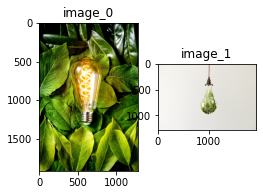

caption_0: some plants surrounding a lightbulb
caption_1: a lightbulb surrounding some plants


In [7]:
from matplotlib import pyplot as plt

def show_example(id):
    ax1 = plt.subplot(1, 3, 1)
    ax1.title.set_text('image_0')
    plt.imshow(winoground[id]["image_0"].convert("RGB"))

    ax2 = plt.subplot(1, 3, 2)
    ax2.title.set_text('image_1')
    plt.imshow(winoground[id]["image_1"].convert("RGB"))

    plt.show()

    print("caption_0:", winoground[id]["caption_0"])
    print("caption_1:", winoground[id]["caption_1"])

show_example(id=155)

In [8]:
def get_blip_scores(id):
    # Note that some images in winoground are RGBA and some are RGB. Need to convert all to RGB with .convert('RGB')
    text_0 = f'Left image {winoground[id]["caption_0"]}'
    text_1 = f'Left image {winoground[id]["caption_1"]}'
    image_0 = load_image(winoground[id]["image_0"].convert("RGB"), image_size, device)
    image_1 = load_image(winoground[id]["image_1"].convert("RGB"), image_size, device)
    images_0_1 = torch.cat([image_0, image_1], dim=0)
    images_1_0 = torch.cat([image_1, image_0], dim=0)

    one_tensor = torch.tensor([1]).to(device)
    zero_tensor = torch.tensor([0]).to(device)
    
    output_c0_i0 = blip_model(text=text_0, image=images_0_1, targets=one_tensor, train=False)
    output_c1_i0 = blip_model(text=text_1, image=images_0_1, targets=zero_tensor, train=False)
    output_c0_i1 = blip_model(text=text_0, image=images_1_0, targets=zero_tensor, train=False)
    output_c1_i1 = blip_model(text=text_1, image=images_1_0, targets=one_tensor, train=False)

    blip_scores_c0_i0 = output_c0_i0[0][1].item()
    blip_scores_c1_i0 = output_c1_i0[0][1].item()
    blip_scores_c0_i1 = output_c0_i1[0][1].item()
    blip_scores_c1_i1 = output_c1_i1[0][1].item()

    blip_scores = {"id": id, "c0_i0": blip_scores_c0_i0, "c0_i1": blip_scores_c0_i1, 
                         "c1_i0": blip_scores_c1_i0, "c1_i1": blip_scores_c1_i1}

    return blip_scores

blip_scores = get_blip_scores(id=155)

In [9]:
def print_scores(scores):
    print("image_0, caption_0:", scores["c0_i0"])
    print("image_0, caption_1:", scores["c1_i0"])
    print("image_1, caption_0:", scores["c0_i1"])
    print("image_1, caption_1:", scores["c1_i1"])

print("BLIP scores:")
print_scores(blip_scores)

BLIP scores:
image_0, caption_0: 3.2934796810150146
image_0, caption_1: 3.3072643280029297
image_1, caption_0: 0.12324383854866028
image_1, caption_1: 3.2351012229919434


# Get BLIP image-caption scores from the whole dataset

In [10]:
from tqdm import tqdm

def get_all_blip_scores():  
    winoground_blip_scores = [] 
    for id in tqdm(range(len(winoground))):
        blip_scores = get_blip_scores(id=id)
        winoground_blip_scores.append(blip_scores)

    return winoground_blip_scores

winoground_blip_scores = get_all_blip_scores()

100%|██████████| 400/400 [03:46<00:00,  1.77it/s]


In [11]:
def save_results(filename, winoground_scores):
    with open(filename, 'w') as f:
        for scores in winoground_scores:
            f.write(f'{{"label": "{scores["id"]}_c0_i0", "score": {scores["c0_i0"]}}}\n')
            f.write(f'{{"label": "{scores["id"]}_c1_i0", "score": {scores["c1_i0"]}}}\n')
            f.write(f'{{"label": "{scores["id"]}_c0_i1", "score": {scores["c0_i1"]}}}\n')
            f.write(f'{{"label": "{scores["id"]}_c1_i1", "score": {scores["c1_i1"]}}}\n')

# path = "/content/drive/MyDrive/PhD/2022 Julen Etxaniz EHU/MAL/winoground/evaluation/"
path = "../"
save_results(path + "../results/scores/blip_b16_nlvr2.jsonl", winoground_blip_scores)

# Define the text, image, and group metrics, and compute the overall performance of BLIP

In [12]:
def text_correct(result):
    return result["c0_i0"] > result["c1_i0"] and result["c1_i1"] > result["c0_i1"]

def image_correct(result):
    return result["c0_i0"] > result["c0_i1"] and result["c1_i1"] > result["c1_i0"]

def group_correct(result):
    return image_correct(result) and text_correct(result)

def print_performance(winoground_scores):
    text_correct_count = 0
    image_correct_count = 0
    group_correct_count = 0
    for result in winoground_scores:
        text_correct_count += 1 if text_correct(result) else 0
        image_correct_count += 1 if image_correct(result) else 0
        group_correct_count += 1 if group_correct(result) else 0

    denominator = len(winoground_scores)
    print("text score:", text_correct_count/denominator)
    print("image score:", image_correct_count/denominator)
    print("group score:", group_correct_count/denominator)

print("BLIP scores:")
print_performance(winoground_blip_scores)

BLIP scores:
text score: 0.4025
image score: 0.25
group score: 0.185
